# miniCDDD

In [1]:
import tensorflow as tf

tf.config.list_physical_devices(device_type='GPU')

2023-08-23 16:33:38.983106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:33:39.497462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/liang/miniconda3/envs/tensorflow/lib:/usr/local/cuda-11.6/lib64
2023-08-23 16:33:39.497504: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/liang/miniconda3/envs/tensorflow/lib:/usr/local/cuda-1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

For demonstration purposes, we have chosen a lightweight dataset. Specifically, we are utilizing the widely-recognized ZINC-250k dataset, which can be found at: https://www.kaggle.com/datasets/basu369victor/zinc250k

In [2]:
import pandas as pd

df = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')

smiles_list = df["smiles"].tolist()
smiles_list = [smile.strip() for smile in smiles_list]

# Preprocessing

During the data preprocessing stage, we referred to a portion of the CDDD source code. Although the original paper claims to use 9 features for training, including maximum/minimum partial charges, we only found 7 features in the source code.

In [3]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Descriptors
import numpy as np

REMOVER = SaltRemover()
ORGANIC_ATOM_SET = set([5, 6, 7, 8, 9, 15, 16, 17, 35, 53])

# Please ensure to check on your own to determine if there are any duplicate values in the data
def process_smiles_list(smiles_list):
    valid_smiles_list = [smiles for smiles in smiles_list if Chem.MolFromSmiles(smiles)]
    canonical_smiles, random_smiles, descriptors = [], [], []

    for sml in valid_smiles_list:
        try:
            mol = Chem.MolFromSmiles(sml)
            if not mol or not (set([atom.GetAtomicNum() for atom in mol.GetAtoms()]) <= ORGANIC_ATOM_SET):
                continue

            if filter_smiles(sml):
                continue

            sml = remove_salt_stereo(sml, REMOVER)
            desc = get_descriptors(sml)
            if np.isnan(desc).any():
                continue

            canonical_smiles.append(sml)
            random_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(sml), doRandom=True))
            descriptors.append(desc)
        except:
            continue
    
    if len(canonical_smiles):
        descriptor_names = [
            "LogP", "Molecular Refractivity", "Balaban J", "Num of H Acceptors", 
            "Num of H Donors", "Num of Valence Electrons", "Topological Polar Surface Area"
        ]

        return pd.DataFrame({
            'canonical_smiles': canonical_smiles,
            'random_smiles': random_smiles,
            **{descriptor_names[i]: [desc[i] for desc in descriptors] for i in range(7)}
        })
        
def filter_smiles(sml):
    mol = Chem.MolFromSmiles(sml)
    logp, mw = Descriptors.MolLogP(mol), Descriptors.MolWt(mol)
    nha, nhd, nhe = Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol), Descriptors.HeavyAtomCount(mol)
    if ((logp > -5) & (logp < 7) &
            (mw > 12) & (mw < 600) &
            (nha > 3) & (nha < 50)):
        return True
    return False

def remove_salt_stereo(sml, remover):
    stripped_sml = Chem.MolToSmiles(remover.StripMol(Chem.MolFromSmiles(sml), dontRemoveEverything=True), isomericSmiles=False)
    return keep_largest_fragment(stripped_sml) if "." in stripped_sml else stripped_sml

def keep_largest_fragment(sml):
    return max([Chem.MolToSmiles(mol) for mol in Chem.GetMolFrags(Chem.MolFromSmiles(sml), asMols=True)], key=len, default=np.float("nan"))

def get_descriptors(sml):
    mol = Chem.MolFromSmiles(sml)
    return [
        Descriptors.MolLogP(mol), Descriptors.MolMR(mol), Descriptors.BalabanJ(mol),
        Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
        Descriptors.NumValenceElectrons(mol), Descriptors.TPSA(mol)
    ]

df = process_smiles_list(smiles_list)
df.head()

,canonical_smiles,random_smiles,LogP,Molecular Refractivity,Balaban J,Num of H Acceptors,Num of H Donors,Num of Valence Electrons,Topological Polar Surface Area
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,c1c2occ(c2cc(C(C)(C)C)c1)CC(Nc1c(cccc1)F)=O,5.05060,93.6477,1.844456,2,1,124,42.24
1,N#Cc1ccc(-c2ccc(OC(C(=O)N3CCCC3)c3ccccc3)cc2)cc1,c1ccc(cc1)C(C(=O)N1CCCC1)Oc1ccc(-c2ccc(C#N)cc2...,4.96778,112.2180,1.550885,3,0,144,53.33
2,CC[NH+](CC)C(C)(CC)C(O)c1cscc1Br,[NH+](CC)(C(C)(C(c1c(csc1)Br)O)CC)CC,2.63740,77.7195,3.044781,2,2,98,24.67
3,CC1CN(C(=O)c2cc(Br)cn2C)CCC1[NH3+],Cn1c(C(=O)N2CC(C)C([NH3+])CC2)cc(c1)Br,0.88010,69.4736,2.130452,2,1,94,52.88
4,O=C(N1CCc2c(F)ccc(F)c2C1)C1(O)Cc2ccccc2C1,C(=O)(N1CCc2c(C1)c(F)ccc2F)C1(Cc2c(cccc2)C1)O,2.37940,84.2788,1.595876,2,1,124,40.54


# Tokenization & Normalization

For the tokenization process, we adopted the regular expression provided by [SmilesPE](https://github.com/XinhaoLi74/SmilesPE/blob/e5f27dfea0778966818ac0a9dd23ac646c62707d/SmilesPE/pretokenizer.py#L15-L18) for atom-wise tokenization. When it comes to padding and preparing both randomized and canonical smiles, our approach closely mirrors the original code. As for the normalization step, we strictly followed the methodology from the original source. This ensures a more stable training process for the classifier model. Without normalization, training this model would be challenging. Hence, we've saved the mean and standard deviation to ensure the model can revert predictions back to the original molecule descriptors values.

In [4]:
import re

# Ref: https://github.com/XinhaoLi74/SmilesPE/blob/e5f27dfea0778966818ac0a9dd23ac646c62707d/SmilesPE/pretokenizer.py#L15-L18
def extract_atoms_from_smiles(smi):
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    return [token for token in regex.findall(smi)]
    
def tokenization(df):
    # Extract unique atoms from the canonical_smiles and create lookup table
    all_atoms = set(atom for smiles in df['canonical_smiles'] for atom in extract_atoms_from_smiles(smiles))
    lookup_table = {atom: idx for idx, atom in enumerate(sorted(all_atoms))}
    
    # Tokenize random_smiles using the lookup table and create a new 'tokens' column
    df['input_tokens'] = df['random_smiles'].apply(lambda s: [lookup_table[atom] for atom in extract_atoms_from_smiles(s)])
    df['output_tokens'] = df['canonical_smiles'].apply(lambda s: [lookup_table[atom] for atom in extract_atoms_from_smiles(s)])
    return df, lookup_table

def pad_tokens_to_max_length_with_lookup(df, lookup_table):
    # Add a new ID for padding in the lookup table
    padding_id = max(lookup_table.values()) + 1
    lookup_table['<PAD>'] = padding_id
    lookup_table['<SOS>'] = padding_id + 1
    lookup_table['<EOS>'] = padding_id + 2
    
    # Find the maximum length from both the columns
    max_length_input = df['input_tokens'].apply(len).max() + 2 # +2 for <SOS> and <EOS>
    max_length_output = df['output_tokens'].apply(len).max() + 2 # +2 for <SOS> and <EOS>
    max_length = max(max_length_input, max_length_output)

    # Pad the tokens with the new padding ID
    df['input_tokens'] = df['input_tokens'].apply(lambda x: [lookup_table['<SOS>']] + x + [lookup_table['<EOS>']] + [padding_id]*(max_length - len(x) - 2))
    df['output_tokens'] = df['output_tokens'].apply(lambda x: [lookup_table['<SOS>']] + x + [lookup_table['<EOS>']] + [padding_id]*(max_length - len(x) - 2))
    
    return df, lookup_table, max_length

def normalize_dataframe(df):
    # Backup the 'canonical_smiles' and 'random_smiles' columns
    canonical_smiles_col = df['canonical_smiles'].copy()
    random_smiles_col = df['random_smiles'].copy()

    # Drop the 'canonical_smiles' and 'random_smiles' columns
    df = df.drop(columns=['canonical_smiles', 'random_smiles'])

    # Compute mean and standard deviation for normalization
    mean, std = df.mean(), df.std()

    # Normalize the dataframe
    df = (df - mean) / std

    # Add the 'canonical_smiles' and 'random_smiles' columns back to the dataframe
    df['canonical_smiles'] = canonical_smiles_col
    df['random_smiles'] = random_smiles_col

    return df, mean, std

df, mean, std = normalize_dataframe(df)
df, lookup_table = tokenization(df) 
df_padded, updated_lookup_table, max_length = pad_tokens_to_max_length_with_lookup(df, lookup_table)

df_padded.head()

,LogP,Molecular Refractivity,Balaban J,Num of H Acceptors,Num of H Donors,Num of Valence Electrons,Topological Polar Surface Area,canonical_smiles,random_smiles,input_tokens,output_tokens
0,1.840308,0.690915,-0.270635,-0.523414,-0.480239,0.501751,-0.405193,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,c1c2occ(c2cc(C(C)(C)C)c1)CC(Nc1c(cccc1)F)=O,"[44, 39, 4, 39, 5, 41, 39, 39, 1, 39, 5, 39, 3...","[44, 13, 13, 1, 13, 2, 1, 13, 2, 39, 4, 39, 39..."
1,1.783509,1.882713,-0.953405,0.794135,-1.627140,1.479772,0.225853,N#Cc1ccc(-c2ccc(OC(C(=O)N3CCCC3)c3ccccc3)cc2)cc1,c1ccc(cc1)C(C(=O)N1CCCC1)Oc1ccc(-c2ccc(C#N)cc2...,"[44, 39, 4, 39, 39, 39, 1, 39, 39, 4, 2, 13, 1...","[44, 17, 0, 13, 39, 4, 39, 39, 39, 1, 3, 39, 5..."
2,0.185311,-0.331320,2.521003,-0.523414,0.666663,-0.769675,-1.404965,CC[NH+](CC)C(C)(CC)C(O)c1cscc1Br,[NH+](CC)(C(C)(C(c1c(csc1)Br)O)CC)CC,"[44, 23, 1, 13, 13, 2, 1, 13, 1, 13, 2, 1, 13,...","[44, 13, 13, 23, 1, 13, 13, 2, 13, 1, 13, 2, 1..."
3,-1.019863,-0.860522,0.394517,-0.523414,-0.480239,-0.965280,0.200247,CC1CN(C(=O)c2cc(Br)cn2C)CCC1[NH3+],Cn1c(C(=O)N2CC(C)C([NH3+])CC2)cc(c1)Br,"[44, 13, 40, 4, 39, 1, 13, 1, 11, 18, 2, 17, 5...","[44, 13, 13, 4, 13, 17, 1, 13, 1, 11, 18, 2, 3..."
4,0.008372,0.089641,-0.848767,-0.523414,-0.480239,0.501751,-0.501927,O=C(N1CCc2c(F)ccc(F)c2C1)C1(O)Cc2ccccc2C1,C(=O)(N1CCc2c(C1)c(F)ccc2F)C1(Cc2c(cccc2)C1)O,"[44, 13, 1, 11, 18, 2, 1, 17, 4, 13, 13, 39, 5...","[44, 18, 11, 13, 1, 17, 4, 13, 13, 39, 5, 39, ..."


# Prepare dataset

The CDDD model has two inputs and two labels. These two inputs correspond to the encoder and the decoder, with the encoder's input being the randomized SMILES. You can also explore other representations mentioned in the paper. It's worth noting that the original paper utilized the teacher forcing technique to stabilize the training of the decoder. As such, we've designed the decoder's input format to meet the requirements of teacher forcing. Regarding the two labels, they represent the outputs of the classifier and the decoder. The classifier's output is normalized, but if it's to be used for predicting molecular descriptors, it needs to be denormalized. The label for the decoder is the canonical SMILES.

In [5]:
def generate_teacher_forcing_dataset(df):
    # Create a tf.data.Dataset with teacher forcing
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'encoder_inputs': df['input_tokens'].tolist(),
            'decoder_inputs': [seq[:-1] for seq in df['output_tokens'].tolist()] # decoder inputs (n-1 elements)
        },
        {
            'decoder': [seq[1:] for seq in df['output_tokens'].tolist()], # decoder targets (from the 2nd element)
            'classifier': df[['LogP', 'Molecular Refractivity', 'Balaban J', 'Num of H Acceptors', 
                                      'Num of H Donors', 'Num of Valence Electrons', 'Topological Polar Surface Area']].values
        }
    ))
    
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=len(df))
    
    # Calculate the number of samples for training (80% of the dataset)
    train_size = int(0.8 * len(df))
    
    # Create training and validation datasets
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    
    return train_dataset, val_dataset

train_dataset, val_dataset = generate_teacher_forcing_dataset(df_padded)

for i, (inputs, outputs) in enumerate(train_dataset.take(1)):
    print(f"Sample {i+1}:")
    print("Encoder Inputs:", inputs['encoder_inputs'])
    print("Decoder Inputs:", inputs['decoder_inputs'])
    print("Decoder Outputs:", outputs['decoder'])
    print("Classification Outputs:", outputs['classifier'])
    print("\n")

Sample 1:
Encoder Inputs: tf.Tensor(
[44 17  4  1 13  5 13 13 13 23  1 13  5  2 13 39  5 39  1 39 39 39  1 12
  2 39  5  2 18 13 13 13  2 13 13 17 13  4 11 18 45 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43], shape=(73,), dtype=int32)
Decoder Inputs: tf.Tensor(
[44 13 13 13 18 39  4 39 39 39  1 12  2 39 39  4 13 23  4 13 13 13 13  1
 17  5 13 13 17 13  5 11 18  2 13  4 45 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43], shape=(72,), dtype=int32)
Decoder Outputs: tf.Tensor(
[13 13 13 18 39  4 39 39 39  1 12  2 39 39  4 13 23  4 13 13 13 13  1 17
  5 13 13 17 13  5 11 18  2 13  4 45 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43], shape=(72,), dtype=int32)
Classification Outputs: tf.Tensor(
[-0.38185372  0.93528405 -0.69254759 -0.52341396  0.66666256  0.8929594
 -0.1906713 ], shape=(7,), dtype=float64)




# Model

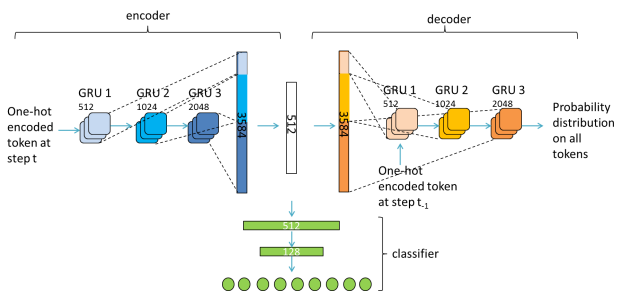

In terms of model design, for better clarity and understanding, we've chosen to construct the model using the Functional API approach. Here, we've decomposed the CDDD model into three components: encoder, decoder, and classifier. The original paper and source code explored various encoder architectures. However, in this repo, we only showcase the architecture deemed best in the original paper, where both the encoder and decoder are composed of RNNs. For the embedding section, we've adhered to the one-hot encoding method as described in the paper, rather than using an embedding layer. **Please note that the output dimension of the classifier is 7, not 9 as shown in the figure above.** Adding dropout and noise makes the model harder to converge. If you just want to quickly obtain model results, it's recommended to comment out the dropout and noise.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TextVectorization, Lambda, Dropout, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)
vocab_size = len(lookup_table)

# Encoder
def build_encoder(input_shape, vocab_size):
    encoder_inputs = Input(shape=input_shape, dtype=tf.int32, name='encoder_inputs')
    x = Lambda(lambda x: tf.one_hot(x, depth=vocab_size))(encoder_inputs)
    x = Dropout(0.15)(x)
    gru_1 = GRU(512, return_sequences=True, return_state=True)(x)
    gru_2 = GRU(1024, return_sequences=True, return_state=True)(gru_1[0])
    gru_3 = GRU(2048, return_sequences=True, return_state=True)(gru_2[0])
    concatenated_states = Concatenate()([gru_1[1], gru_2[1], gru_3[1]])
    dense_latent = Dense(512, activation='tanh')(concatenated_states)
    dense_latent = GaussianNoise(0.05)(dense_latent)
    
    return Model(encoder_inputs, dense_latent, name='encoder')

# Decoder
def build_decoder(input_shape, vocab_size, latent_dim):
    decoder_inputs = Input(shape=input_shape, dtype=tf.int32, name='decoder_inputs')
    x = Lambda(lambda x: tf.one_hot(x, depth=vocab_size))(decoder_inputs)
    initial_states_input = Input(shape=(latent_dim,))
    dense_latent = Dense(3584, activation='relu')(initial_states_input)
    initial_state_gru_1 = tf.slice(dense_latent, [0, 0], [-1, 512])
    initial_state_gru_2 = tf.slice(dense_latent, [0, 512], [-1, 1024])
    initial_state_gru_3 = tf.slice(dense_latent, [0, 512+1024], [-1, 2048])
    dec_gru_1 = GRU(512, return_sequences=True)(x, initial_state=initial_state_gru_1)
    dec_gru_2 = GRU(1024, return_sequences=True)(dec_gru_1, initial_state=initial_state_gru_2)
    dec_gru_3 = GRU(2048, return_sequences=True)(dec_gru_2, initial_state=initial_state_gru_3)
    outputs = Dense(vocab_size, activation='softmax', name='reconstruction_output')(dec_gru_3)
    
    return Model([decoder_inputs, initial_states_input], outputs, name='decoder')

# Classifier
def build_classification_model(latent_dim):
    latent_input = Input(shape=(latent_dim,))
    y = Dense(512, activation='relu')(latent_input)
    y = Dense(128, activation='relu')(y)
    classification_output = Dense(7, name='classification_output')(y)
    
    return Model(latent_input, classification_output, name='classifier')

# Building the models
encoder = build_encoder((None,), vocab_size)
decoder = build_decoder((None,), vocab_size, 512)
classifier = build_classification_model(512)

encoder.summary()
decoder.summary()
classifier.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 lambda (Lambda)                (None, None, 46)     0           ['encoder_inputs[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, None, 46)     0           ['lambda[0][0]']                 
                                                                                                  
 gru (GRU)                      [(None, None, 512),  860160      ['dropout[0][0]']                
                                 (None, 512)]                                               

In [7]:
encoder_inputs = Input(shape=(None,), dtype=tf.int32, name='encoder_inputs')
decoder_inputs = Input(shape=(None,), dtype=tf.int32, name='decoder_inputs')

main_encoder_output = encoder(encoder_inputs)
classification_outputs = classifier(main_encoder_output)
reconstruction_outputs = decoder([decoder_inputs, main_encoder_output])

main_model = Model([encoder_inputs, decoder_inputs], [reconstruction_outputs, classification_outputs], name='miniCDDD')
main_model.summary()

Model: "miniCDDD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder (Functional)           (None, 512)          26307072    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder (Functional)           (None, None, 46)     26404398    ['decoder_inputs[0][0]',         
                                                                  'encoder[0][0]']         

For training parameters and optimizer settings, we followed the recommendations provided in the original paper.

In [8]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define the learning rate schedule
initial_learning_rate = 5e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50000,
    decay_rate=0.9,
    staircase=True
)

# Create an Adam optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer.build(main_model.trainable_variables)

# Compile the model
main_model.compile(optimizer=optimizer, 
              loss={'decoder': 'SparseCategoricalCrossentropy', 'classifier': 'mse'},
              metrics={'decoder': ['accuracy'], 'classifier': ['mse']})

# Training

In [9]:
BATCH_SIZE = 64
EPOCHS = 100

# Batch the datasets
train_dataset_batched = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset_batched = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Training the model
history = main_model.fit(train_dataset_batched, epochs=EPOCHS, validation_data=val_dataset_batched, callbacks=[early_stopping])

Epoch 1/100
1292/1292 [==============================] - 125s 93ms/step - loss: 1.4842 - decoder_loss: 0.4819 - classifier_loss: 1.0023 - decoder_accuracy: 0.8466 - classifier_mse: 1.0023 - val_loss: 1.3533 - val_decoder_loss: 0.3477 - val_classifier_loss: 1.0057 - val_decoder_accuracy: 0.8821 - val_classifier_mse: 1.0057
Epoch 2/100
1292/1292 [==============================] - 121s 93ms/step - loss: 1.3333 - decoder_loss: 0.3327 - classifier_loss: 1.0006 - decoder_accuracy: 0.8854 - classifier_mse: 1.0006 - val_loss: 1.3188 - val_decoder_loss: 0.3144 - val_classifier_loss: 1.0044 - val_decoder_accuracy: 0.8901 - val_classifier_mse: 1.0044
Epoch 3/100
1292/1292 [==============================] - 121s 93ms/step - loss: 1.3179 - decoder_loss: 0.3155 - classifier_loss: 1.0024 - decoder_accuracy: 0.8906 - classifier_mse: 1.0024 - val_loss: 1.2995 - val_decoder_loss: 0.2968 - val_classifier_loss: 1.0027 - val_decoder_accuracy: 0.8959 - val_classifier_mse: 1.0027
Epoch 4/100
1292/1292 [=====

## Save tokenizer & model

We have saved several model combinations, namely: encoder, encoder + classifier, and encoder + decoder. You can use them according to your needs. Additionally, we have saved the tokenizer in a `.json` file.

In [14]:
# Save tokenizer
import json

def save_lookup_table(lookup_table, filename):
    with open(filename, 'w') as f:
        json.dump(lookup_table, f)

lookup_table_filename = "lookup_table.json"
save_lookup_table(lookup_table, lookup_table_filename)

# Save main_model
main_model.save('./models/miniCDDD_model.h5')

# Save encoder
encoder.save('./models/encoder_model.h5')

# Save encoder + decoder
def build_seq2seq_model(encoder, decoder, input_shape, vocab_size):
    # Encoder Inputs
    encoder_inputs = Input(shape=input_shape, dtype=tf.int32, name='encoder_inputs')
    encoder_outputs = encoder(encoder_inputs)
    
    # Decoder Inputs
    decoder_inputs = Input(shape=input_shape, dtype=tf.int32, name='decoder_inputs')
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    
    # Combined model
    return Model([encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_model')

seq2seq_model = build_seq2seq_model(encoder, decoder, (None,), vocab_size)
seq2seq_model.save('./models/seq2seq_model.h5')

# Save encoder + classifier
def build_classifier_model(encoder, classifier, mean, std, input_shape):
    class DenormalizationLayer(tf.keras.layers.Layer):
        def __init__(self, mean, std, **kwargs):
            super(DenormalizationLayer, self).__init__(**kwargs)
            self.mean = tf.constant(mean, dtype=tf.float32)
            self.stddev = tf.constant(std, dtype=tf.float32)
            
        def call(self, inputs):
            return inputs * self.stddev + self.mean
        
        def get_config(self):
            config = super().get_config()
            config.update({
                "mean": self.mean.numpy(),
                "std": self.stddev.numpy()
            })
            return config
    
    denormalization_layer = DenormalizationLayer(mean, std)

    encoder_inputs = tf.keras.Input(shape=input_shape, name="encoder_inputs")
    encoder_outputs = encoder(encoder_inputs)
    classifier_outputs = classifier(encoder_outputs)
    classifier_outputs_denormalized = denormalization_layer(classifier_outputs)

    return tf.keras.Model(inputs=encoder_inputs, outputs=classifier_outputs_denormalized, name='classifier_model')

classifier_model = build_classifier_model(encoder, classifier, mean, std, (None,))
classifier_model.save('./models/classifier_model.h5')

## Metrics

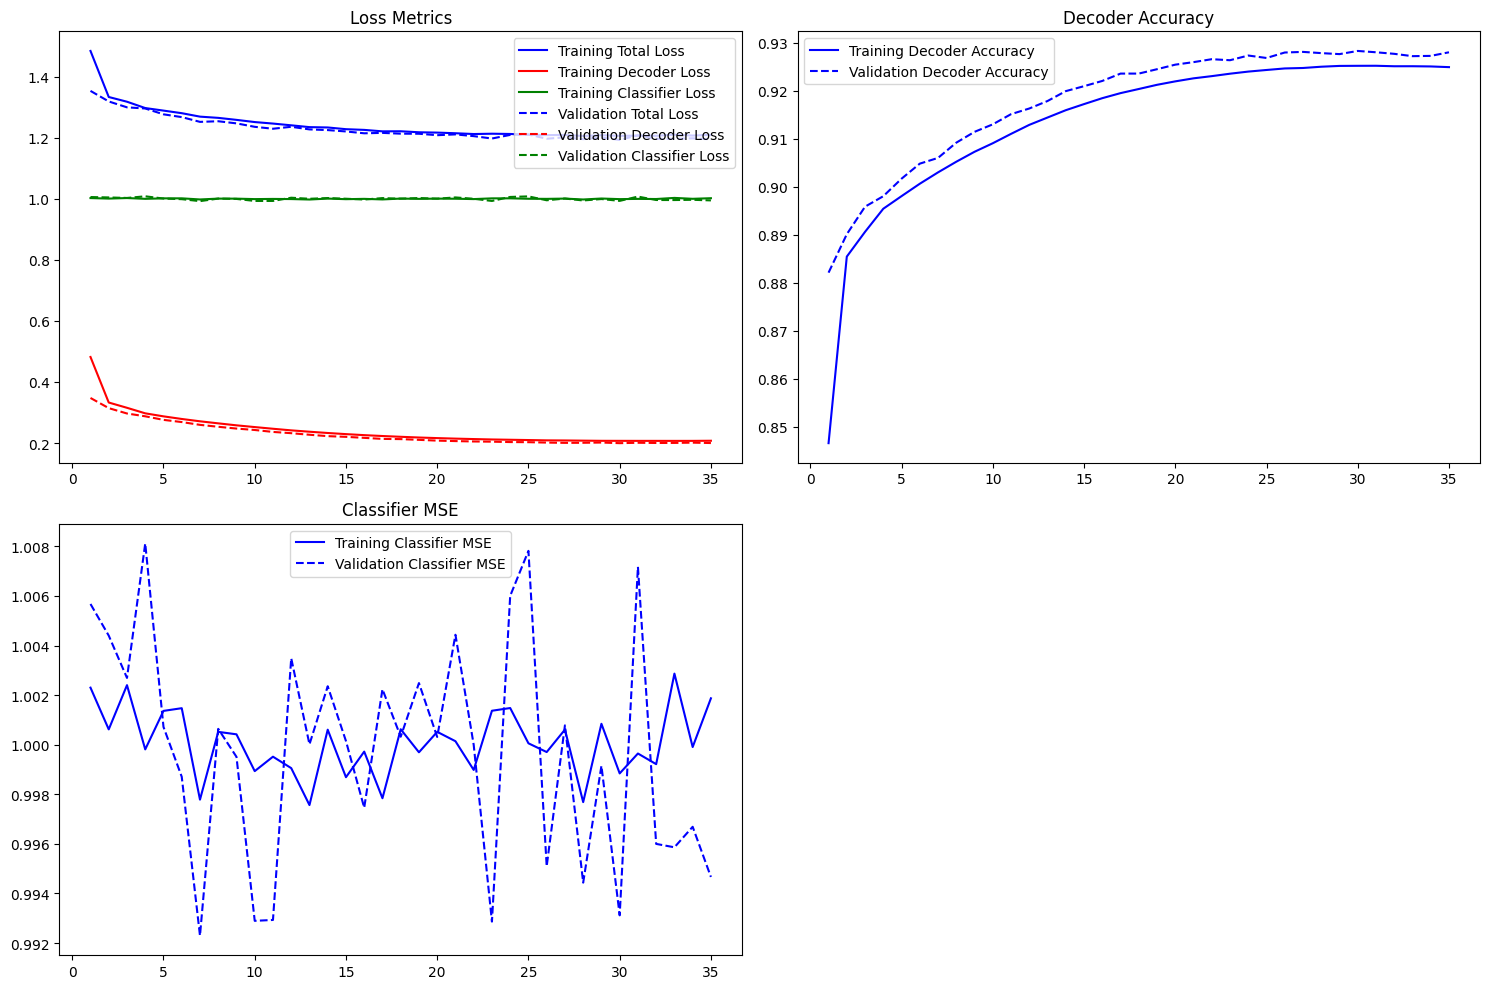

In [15]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    loss = history['loss']
    decoder_loss = history['decoder_loss']
    classifier_loss = history['classifier_loss']
    decoder_accuracy = history['decoder_accuracy']
    classifier_mse = history['classifier_mse']
    
    val_loss = history.get('val_loss', None)
    val_decoder_loss = history.get('val_decoder_loss', None)
    val_classifier_loss = history.get('val_classifier_loss', None)
    val_decoder_accuracy = history.get('val_decoder_accuracy', None)
    val_classifier_mse = history.get('val_classifier_mse', None)

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Total Loss')
    plt.plot(epochs, decoder_loss, 'r-', label='Training Decoder Loss')
    plt.plot(epochs, classifier_loss, 'g-', label='Training Classifier Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'b--', label='Validation Total Loss')
        plt.plot(epochs, val_decoder_loss, 'r--', label='Validation Decoder Loss')
        plt.plot(epochs, val_classifier_loss, 'g--', label='Validation Classifier Loss')
    plt.title('Loss Metrics')
    plt.legend()

    # Plotting Decoder Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, decoder_accuracy, 'b-', label='Training Decoder Accuracy')
    if val_decoder_accuracy:
        plt.plot(epochs, val_decoder_accuracy, 'b--', label='Validation Decoder Accuracy')
    plt.title('Decoder Accuracy')
    plt.legend()

    # Plotting Classifier MSE
    plt.subplot(2, 2, 3)
    plt.plot(epochs, classifier_mse, 'b-', label='Training Classifier MSE')
    if val_classifier_mse:
        plt.plot(epochs, val_classifier_mse, 'b--', label='Validation Classifier MSE')
    plt.title('Classifier MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(history.history)

# Inference (Predicit molecular descriptors)

## Load tokenizer

In [16]:
import json
import re

class SmilesTokenizer:
    def __init__(self, lookup_filename, max_length=73):
        self.lookup_table = self._load_lookup_table(lookup_filename)
        self.max_length = max_length
        
    def _load_lookup_table(self, filename):
        with open(filename, 'r') as f:
            return json.load(f)
        
    def _pad_tokens_to_max_length(self, tokens):
        padding_id = self.lookup_table['<PAD>']
        sos_id = self.lookup_table['<SOS>']
        eos_id = self.lookup_table['<EOS>']
        return [sos_id] + tokens + [eos_id] + [padding_id] * (self.max_length - len(tokens) - 2)
    
    def _extract_atoms_from_smiles(self, smi):
        pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
        regex = re.compile(pattern)
        return [token for token in regex.findall(smi)]
    
    def tokenize(self, smiles_string):
        tokens = [self.lookup_table[atom] for atom in self._extract_atoms_from_smiles(smiles_string)]
        padded_tokens = self._pad_tokens_to_max_length(tokens)
        return np.array(padded_tokens)

tokenizer = SmilesTokenizer('./lookup_table.json')

## Classifier

In [17]:
class DenormalizationLayer(tf.keras.layers.Layer):
    def __init__(self, mean, std, **kwargs):
        super(DenormalizationLayer, self).__init__(**kwargs)
        self.mean = tf.constant(mean, dtype=tf.float32)
        self.stddev = tf.constant(std, dtype=tf.float32)

    def call(self, inputs):
        return inputs * self.stddev + self.mean

    def get_config(self):
        config = super().get_config()
        config.update({
            "mean": self.mean.numpy(),
            "std": self.stddev.numpy()
        })
        return config
        
trained_classifier_model = tf.keras.models.load_model('./models/classifier_model.h5', custom_objects={'DenormalizationLayer': DenormalizationLayer})

In [18]:
trained_classifier_model.predict(tokenizer.tokenize('CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1').reshape(1,-1))

1/1 [==============================] - 0s 477ms/step


array([[  2.3730838,  82.84353  ,   1.9643699,   2.3969407,   1.4171944,
        113.64999  ,  49.330345 ]], dtype=float32)

## Seq2Seq

*TODO...*

## Encoder

In [19]:
trained_encoder_model = tf.keras.models.load_model('./models/encoder_model.h5')

In [20]:
trained_encoder_model.predict(tokenizer.tokenize('CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1').reshape(1,-1)).shape

1/1 [==============================] - 1s 695ms/step


(1, 512)